# 1 - Quick start with Hookean dumbbells

## Background

The dumbbell is one of the oldest and simplest model for polymer solutions, yet it entails many fundamental features of these liquids. A molecule is described by two beads linked by a linear (Hookean) spring of constant $\kappa=3kT/\ell^2$ with $kT$ the usual thermal energy, and $\ell$ the average end-to-end distance of the unperturbed chain. Each bead experiences a friction force $-\zeta V$ with $\zeta$ the (constant) friction coefficient and $V=\dot{X}-U$ the relative velocity between the bead and the underlying solvent velocity field $U$. If the centre of mass of the dumbbell moves with the flow and we take this centre as the origin of the coordinate system, then $V\approx\dot{X}-X\nabla U$. Finally, the effect of multiple collisions with the solvent molecules are modelled by a random walk, so that each bead obey a stochastic differential equation:

\begin{equation}
\begin{alignedat}{1}\mathrm{d}X_{0} & =\mathrm{d}t\left(X_{0}\nabla U+\frac{\kappa}{\zeta}(X_{1}-X_{0})\right)+\mathrm{d}W_{0}\\
\mathrm{d}X_{1} & =\mathrm{d}t\left(X_{1}\nabla U-\frac{\kappa}{\zeta}(X_{1}-X_{0})\right)+\mathrm{d}W_{1}
\end{alignedat}
\end{equation}

where the random vectors $\mathrm{d}W_i$ are drawn from a normal distribution with zero mean and variance $2 kT \mathrm{d}t/\zeta$ per each coordinate. By summing, we get the equation for the end-to-end vector $Q$:

\begin{equation}
\mathrm{d}Q =\mathrm{d}t\left(Q\nabla U-2\frac{\kappa}{\zeta} Q\right) + \mathrm{d}W
\end{equation}

with this time the variance of $dW$ being $4kT\mathrm{d}t/\zeta$ in each coordinate. We can identify a relaxation time 

\begin{equation}
\tau = \frac{\zeta}{2\kappa}
\end{equation}

and put this equation in dimentionless form, taking $\tau/2$ as the time scale and $\ell$ as the length scale:

\begin{equation}
\mathrm{d}Q^* =\mathrm{d}t^*\left(Q^* (\nabla U)^* - \frac{Q^*}{2}\right) +\mathrm{d}W^*
\end{equation}

Now the variance of $\mathrm{d}W^*$ is $\mathrm{d}t^*/3$ in each coordinate.

> The fact that we take $\tau/2$ and not $\tau$ for the timescale is to stick with the rheology convention, where we want the dimensionless stress tensor to relax with unit dimensionless time.


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.Hookean_dumbbell import HookeanDumbbell

## Parameters definition

In [2]:
n_ensemble = 1000   # Number of molecules to simulate
n_rec = 1000        # Number of time steps to record
dt = .001           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use
                    

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution with variance ⅓ in each coordinate so that the average norm is 1. To do this with call `from_normal_distribution` constructor. Note that we pass a random seed (`SeedSequence` object) to ensure thread-safe random number generation and reproducible results.

In [3]:
seq = np.random.SeedSequence(2022)
seeds = seq.spawn(n_ensemble)
# Starting vectors
molecules = [HookeanDumbbell.from_normal_distribution(seed)
             for seed in seeds]

## Initial relaxation
Molecular dynamics simulations are usually preceeded by a relaxation/thermalisation step, which in our case is just a simulation with no velocity gradient. Although we know that for Hookean dumbbell the relaxed distribution is the one we just used to create new molecules, we still do it as an example of a first call to the `simulate_batch` function.

In [4]:
gradU = np.zeros((3, 3))
observables, molecules_out = simulate_batch(molecules, gradU, n_rec, dt, n_proc)

Physical time to compute: 1.0
Calculation started on 16 cores.


100%|██████████| 1000/1000 [00:05<00:00, 172.85it/s]


We can investigate the dumbbell distribution in a number of ways. Let's look at time series and histograms.

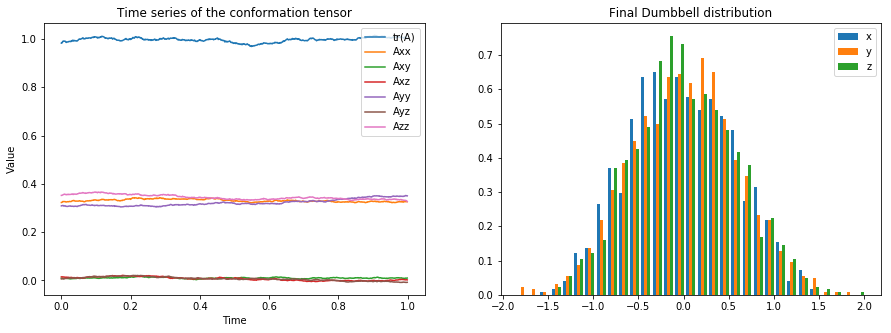

In [5]:
A = observables['A_average']
t = np.arange(n_rec)*dt
trA = np.trace(A, axis1=1, axis2=2)
Qs = np.array([molecule.Q for molecule in molecules_out])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([Qs[:,0], Qs[:,1], Qs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final Dumbbell distribution')
plt.show()

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We could simulate this scenario with constant velocity gradients and stitch the results together, but we can also use the interpolator `scipy.interpolate.interp1d` with the property `kind=previous`. This is more flexible and we will use linear interpolation in other examples.

In [6]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          1] # Relaxation will start from t = 1
gradU_base = [np.diag([1., -0.5, -0.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [7]:
n_rec = 2000
observables, molecules_out = simulate_batch(molecules_out, gradU, n_rec, dt, n_proc)

Physical time to compute: 2.0
Calculation started on 16 cores.


100%|██████████| 1000/1000 [00:25<00:00, 38.80it/s]


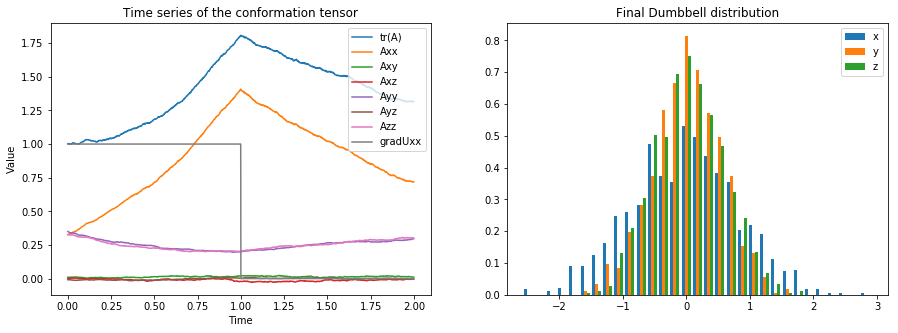

In [8]:
A = observables['A_average']
t = np.arange(n_rec)*dt
trA = np.trace(A, axis1=1, axis2=2)
Qs = np.array([molecule.Q for molecule in molecules_out])
gradUeval = gradU(t)


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].plot(t, gradUeval[:,0,0], label='gradUxx')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([Qs[:,0], Qs[:,1], Qs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final Dumbbell distribution')
plt.show()

## Save result to a file
Here we save the result as *numpy arrays* compressed in a single file, as we expect further analysis with Python. Use other tools to save as text files.

In [9]:
params = {'model' : molecules[0].__class__.__name__,
          'model_attributes' : molecules[0].__dict__,
          'n_ensemble' : n_ensemble,
          'n_rec' : n_rec,
          'dt' : dt,
          'n_proc' : n_proc
          }
np.savez_compressed(output_file, t=t, gradU=gradUeval, **observables, params=params)